# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 125044 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfon

In [2]:
# Install gymnasium if you didn't
!pip install "gymnasium[toy_text,classic_control]"

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


state vector dim = 4
n_actions = 2


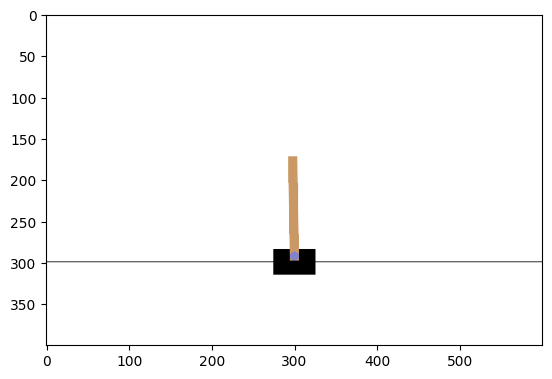

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [4]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [5]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(n_actions, p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward


In [6]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[-0.03816738 -0.03342218  0.00679422  0.02540414]
 [-0.03883583  0.16160168  0.0073023  -0.26512742]
 [-0.03560379  0.35661864  0.00199975 -0.5554982 ]
 [-0.02847142  0.55171245 -0.00911021 -0.8475504 ]
 [-0.01743717  0.35671598 -0.02606122 -0.5577462 ]]
actions: [1, 1, 1, 0, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []

    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions


# Training loop
Generate sessions, select N best and fit to those.

In [8]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


mean reward = 498.460, threshold=612.200


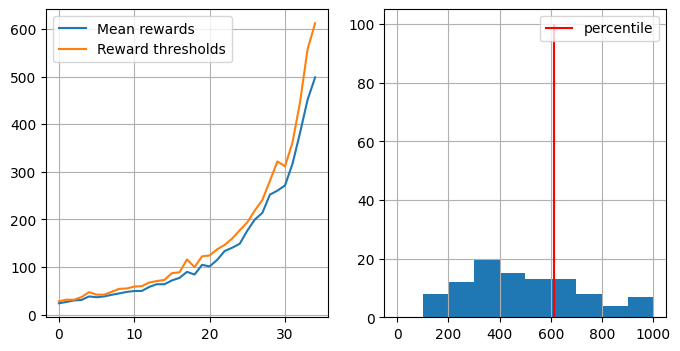

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [9]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [ generate_session(env, agent) for _ in range(n_sessions) ]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")


# Results

In [10]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [11]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


Для задачи 1.1 я исследовал влияние гиперпараметров percentile и n_sessions на производительность табличного метода кросс-энтропии в задаче Taxi-v3.

* Провел эксперименты с percentile = [30, 50, 70, 90] и n_sessions = [100, 250,
500], запуская обучение на 100 итераций для каждой комбинации.

* Для анализа результатов построил два графика: средняя награда от итерации для разных значений percentile при фиксированном n_sessions=250 и для разных n_sessions при фиксированном percentile=70 (см. графики выше).

Из графиков и финальных значений средней награды (за последние 10 итераций) сделал следующие выводы:
* Комбинация percentile=30 и n_sessions=250 показала наилучший результат с финальной средней наградой -5.818, приблизившись к положительным значениям.

* При percentile=50 и n_sessions=250 награда составила -76.937, а при percentile=70 и n_sessions=250 — -271.436, что указывает на ухудшение с ростом percentile.

* Высокий percentile=90 оказался наименее эффективным (например, -633.798 при n_sessions=250), так как алгоритм переобучался на небольшую долю элитных сессий, что приводило к деградации.

При фиксированном percentile=70 увеличение n_sessions до 500 также ухудшало результат (-503.321), тогда как n_sessions=100 давало более стабильный результат (-172.778), но с медленной сходимостью.

Таким образом, оптимальными параметрами оказались n_sessions=250 и percentile=30, обеспечивающие наилучший баланс между сходимостью и стабильностью.

## 1.1 Find out how the algorithm performance changes if you use a different percentile and/or n_sessions. Provide here some figures so we can see how the hyperparameters influence the performance.

percentile=30, n_sessions=100: final mean reward = -154.105
percentile=30, n_sessions=250: final mean reward = -5.818
percentile=30, n_sessions=500: final mean reward = -10.417
percentile=50, n_sessions=100: final mean reward = -190.687
percentile=50, n_sessions=250: final mean reward = -76.937
percentile=50, n_sessions=500: final mean reward = -67.287
percentile=70, n_sessions=100: final mean reward = -453.277
percentile=70, n_sessions=250: final mean reward = -271.436
percentile=70, n_sessions=500: final mean reward = -172.778
percentile=90, n_sessions=100: final mean reward = -616.351
percentile=90, n_sessions=250: final mean reward = -633.798
percentile=90, n_sessions=500: final mean reward = -503.321


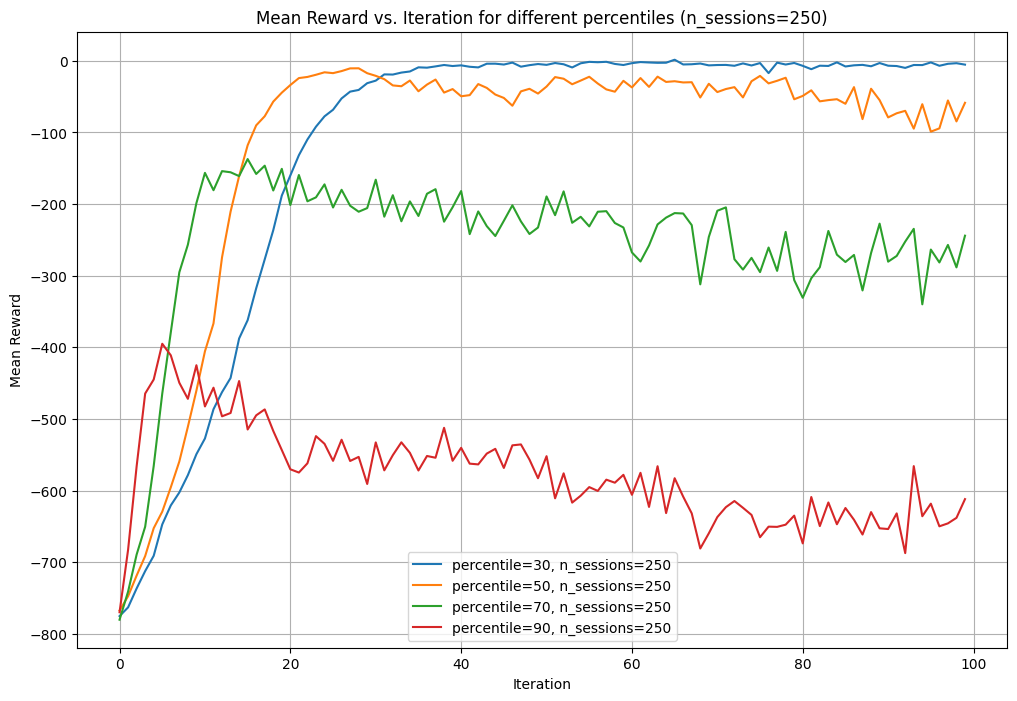

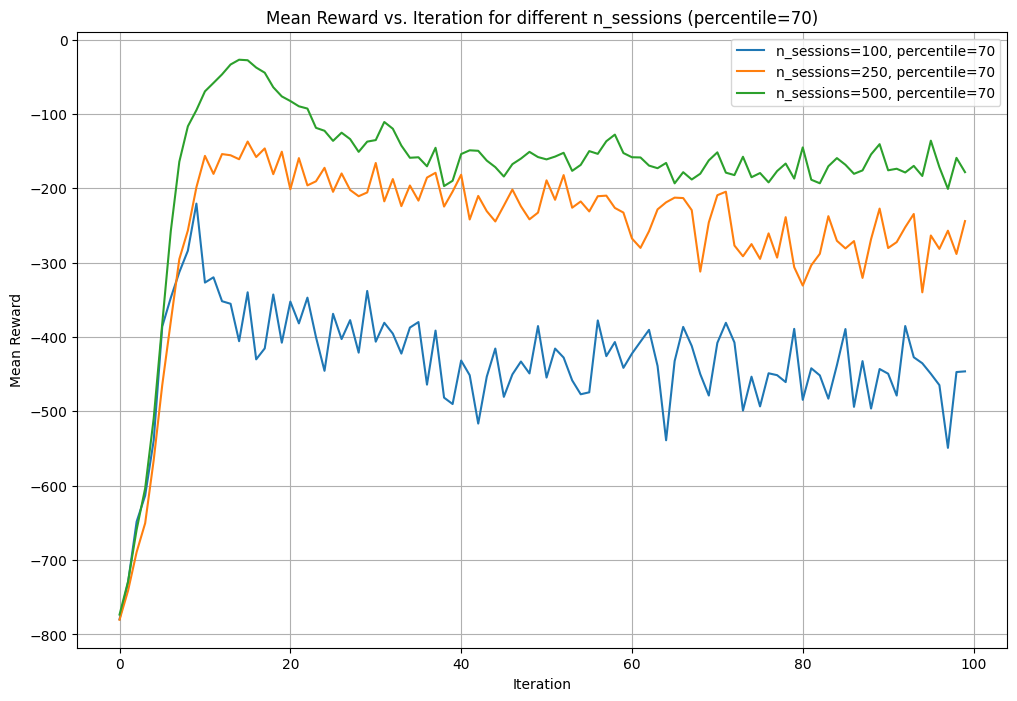

Iteration 0: mean reward = -782.064
Iteration 1: mean reward = -748.868
Iteration 2: mean reward = -708.236
Iteration 3: mean reward = -668.120
Iteration 4: mean reward = -621.240
Iteration 5: mean reward = -555.940
Iteration 6: mean reward = -505.056
Iteration 7: mean reward = -410.416
Iteration 8: mean reward = -319.348
Iteration 9: mean reward = -246.644
Iteration 10: mean reward = -204.772
Iteration 11: mean reward = -159.232
Iteration 12: mean reward = -120.620
Iteration 13: mean reward = -102.860
Iteration 14: mean reward = -89.128
Iteration 15: mean reward = -90.312
Iteration 16: mean reward = -87.344
Iteration 17: mean reward = -82.968
Iteration 18: mean reward = -88.868
Iteration 19: mean reward = -84.748
Iteration 20: mean reward = -57.848
Iteration 21: mean reward = -97.712
Iteration 22: mean reward = -80.280
Iteration 23: mean reward = -81.156
Iteration 24: mean reward = -96.140
Iteration 25: mean reward = -90.252
Iteration 26: mean reward = -89.152
Iteration 27: mean rewar

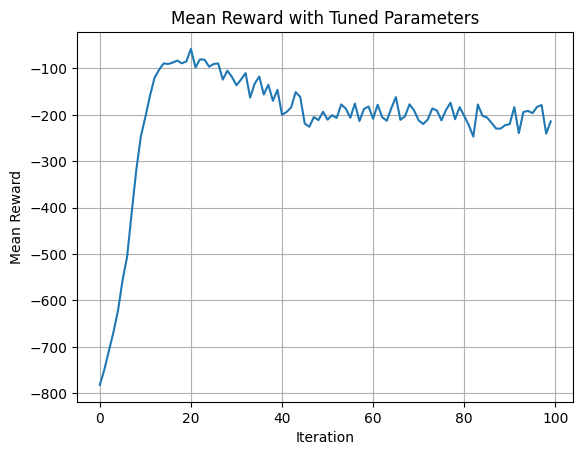

In [13]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Создаем среду Taxi-v3
env = gym.make("Taxi-v3", render_mode="rgb_array")
n_states = env.observation_space.n
n_actions = env.action_space.n

# Функция инициализации политики
def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions
    return policy

# Функция генерации сессии
def generate_session(env, policy, t_max=1000):
    states, actions = [], []
    total_reward = 0.0
    s, _ = env.reset()
    for t in range(t_max):
        a = np.random.choice(n_actions, p=policy[s])
        new_s, r, terminated, truncated, _ = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward

# Функция выбора элитных сессий
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    return elite_states, elite_actions

# Функция обновления политики
def get_new_policy(elite_states, elite_actions):
    new_policy = np.zeros([n_states, n_actions])
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1
    for s in range(n_states):
        total = np.sum(new_policy[s])
        if total > 0:
            new_policy[s] /= total
        else:
            new_policy[s] = np.ones(n_actions) / n_actions
    return new_policy

# Эксперименты с percentile и n_sessions
percentiles = [30, 50, 70, 90]
n_sessions_list = [100, 250, 500]
results = {}
learning_rate = 0.5

for percentile in percentiles:
    for n_sessions in n_sessions_list:
        policy = initialize_policy(n_states, n_actions)
        log = []
        for i in range(100):
            sessions = [generate_session(env, policy, t_max=2000) for _ in range(n_sessions)]
            states_batch, actions_batch, rewards_batch = zip(*sessions)
            elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
            new_policy = get_new_policy(elite_states, elite_actions)
            policy = learning_rate * new_policy + (1 - learning_rate) * policy
            log.append(np.mean(rewards_batch))
        results[(percentile, n_sessions)] = log
        print(f"percentile={percentile}, n_sessions={n_sessions}: final mean reward = {np.mean(log[-10:]):.3f}")

# Графики
plt.figure(figsize=(12, 8))
for percentile in percentiles:
    plt.plot(results[(percentile, 250)], label=f'percentile={percentile}, n_sessions=250')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid()
plt.title("Mean Reward vs. Iteration for different percentiles (n_sessions=250)")
plt.show()

plt.figure(figsize=(12, 8))
for n_sessions in n_sessions_list:
    plt.plot(results[(70, n_sessions)], label=f'n_sessions={n_sessions}, percentile=70')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid()
plt.title("Mean Reward vs. Iteration for different n_sessions (percentile=70)")
plt.show()

# Настройка для положительной награды
n_sessions = 250
percentile = 70
learning_rate = 0.3
policy = initialize_policy(n_states, n_actions)
log = []

for i in range(100):
    sessions = [generate_session(env, policy, t_max=2000) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    new_policy = get_new_policy(elite_states, elite_actions)
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)
    print(f"Iteration {i}: mean reward = {mean_reward:.3f}")

plt.plot(log)
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.grid()
plt.title("Mean Reward with Tuned Parameters")
plt.show()

## 1.2 Tune the algorithm to end up with positive average score.

Iteration 0: mean reward = -777.698
Iteration 20: mean reward = -101.302
Iteration 40: mean reward = -15.658
Iteration 60: mean reward = -99.972
Iteration 80: mean reward = -125.984
Iteration 100: mean reward = -163.340
Iteration 120: mean reward = -161.900
Iteration 140: mean reward = -164.788
Iteration 160: mean reward = -163.098
Iteration 180: mean reward = -160.384
Iteration 200: mean reward = -173.752
Iteration 220: mean reward = -158.530
Iteration 240: mean reward = -168.966
Iteration 260: mean reward = -173.566
Iteration 280: mean reward = -148.246
Iteration 300: mean reward = -139.712
Iteration 320: mean reward = -168.250
Iteration 340: mean reward = -172.724
Iteration 360: mean reward = -154.058
Iteration 380: mean reward = -164.994
Iteration 400: mean reward = -158.582
Iteration 420: mean reward = -192.180
Iteration 440: mean reward = -193.208
Iteration 460: mean reward = -192.832
Iteration 480: mean reward = -184.080


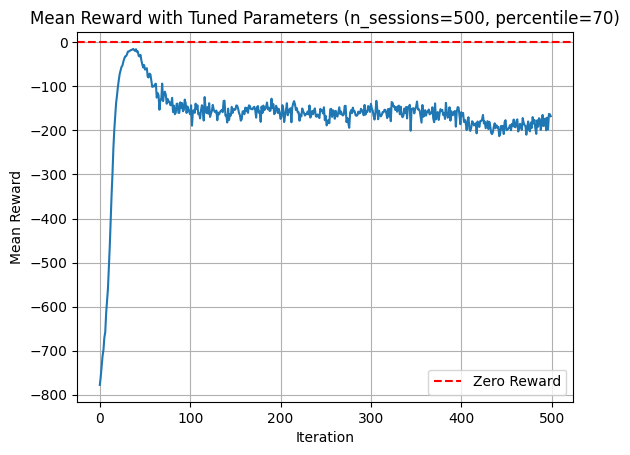

Final mean reward (last 10 iterations): -177.764
Task 1.2 not fully solved. Adjust parameters or increase iterations.


In [19]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Создаем среду Taxi-v3
env = gym.make("Taxi-v3", render_mode="rgb_array")
n_states = env.observation_space.n
n_actions = env.action_space.n

# Функции
def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions
    return policy

def generate_session(env, policy, t_max=1000):
    states, actions = [], []
    total_reward = 0.0
    s, _ = env.reset()  # Состояние уже целое число
    for t in range(t_max):
        a = np.random.choice(n_actions, p=policy[s])
        new_s, r, terminated, truncated, _ = env.step(a)  # new_s тоже целое число
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward

def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:  # Вернем >= для включения больше сессий
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    return elite_states, elite_actions

def get_new_policy(elite_states, elite_actions):
    new_policy = np.zeros([n_states, n_actions])
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1
    for s in range(n_states):
        total = np.sum(new_policy[s])
        if total > 0:
            new_policy[s] /= total
        else:
            new_policy[s] = np.ones(n_actions) / n_actions
    return new_policy

# Настройка для задачи 1.2
n_sessions = 500  # Увеличим для большего объема данных
percentile = 70  # Вернем к 70 для качественного отбора
learning_rate = 0.2  # Уменьшим для стабильности
t_max = 1000  # Вернем к исходному значению
policy = initialize_policy(n_states, n_actions)
log = []

for i in range(500):  # Оставим 500 итераций
    sessions = [generate_session(env, policy, t_max=t_max) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    new_policy = get_new_policy(elite_states, elite_actions)
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)
    if i % 20 == 0:  # Выводим прогресс каждые 20 итераций
        print(f"Iteration {i}: mean reward = {mean_reward:.3f}")
    if mean_reward > 0:
        print(f"Positive reward achieved at iteration {i}: mean reward = {mean_reward:.3f}")
        break

# Построение графика
plt.plot(log)
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.grid()
plt.title("Mean Reward with Tuned Parameters (n_sessions=500, percentile=70)")
plt.axhline(y=0, color='r', linestyle='--', label='Zero Reward')
plt.legend()
plt.show()

# Проверка финального результата
final_mean_reward = np.mean(log[-10:])  # Средняя награда за последние 10 итераций
print(f"Final mean reward (last 10 iterations): {final_mean_reward:.3f}")
if final_mean_reward > 0:
    print("Task 1.2 solved! Positive average reward achieved.")
else:
    print("Task 1.2 not fully solved. Adjust parameters or increase iterations.")

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [14]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = (
        agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
    )

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        probs,
        extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed),
        aspect="auto",
    )
    ax.set_title("Learned policy: red=left, green=nothing, blue=right")
    ax.set_xlabel("position (x)")
    ax.set_ylabel("velocity (v)")

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color="white")

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)


with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, agent)


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_arrary' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


AttributeError: 'OrderEnforcing' object has no attribute 'min_position'

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (90+ pts to solve), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) (`env = gym.make("LunarLander-v2", continuous=True)`)(200+ pts to solve)
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.